In [7]:
import tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib

In [3]:


health_data =  pd.read_csv('../merged_final_data_heavy_filtered.csv')

In [4]:
print(health_data.columns)

Index(['Age', 'Gender', 'Race', 'Tobacco smoking status NHIS',
       'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
       'Heart rate', 'Body Height', 'Body Weight', 'Body Mass Index',
       'Hemoglobin [Mass/volume] in Blood', 'Systolic Blood Pressure',
       'Diastolic Blood Pressure',
       'Stress is when someone feels tense  nervous  anxious or can't sleep at night because their mind is troubled. How stressed are you?',
       'Hypertension'],
      dtype='object')


In [8]:
columns_to_encode = ['Tobacco smoking status NHIS',  
                    "Stress is when someone feels tense  nervous  anxious or can't sleep at night because their mind is troubled. How stressed are you?", 
                    "Gender", 
                     "Race"]
OHE    = OneHotEncoder(sparse=False)
encoded_columns =    OHE.fit_transform(health_data[columns_to_encode])
joblib.dump(OHE, '../weights/encoder.joblib')
                     
                     

['../weights/encoder.joblib']

In [9]:
print(encoded_columns.shape)

(45459, 17)


In [10]:
column_name = OHE.get_feature_names(columns_to_encode)
one_hot_encoded_frame =  pd.DataFrame(encoded_columns, columns= column_name)

In [11]:
only_scalar = health_data.drop(columns_to_encode, axis=1)


In [14]:
#only_scalar_filtered_frame =only_scalar.drop(['TIME','PATIENT'], axis=1) #filter time and patient
only_scalar_filtered_frame  = only_scalar
final_frame = pd.concat([one_hot_encoded_frame,only_scalar_filtered_frame], axis=1)

In [15]:
encoded_full_column_list = final_frame.columns

In [16]:
final_frame.to_csv("./feature_selection/final_Frame.csv")

Shuffle the dataset.

In [17]:
from sklearn.utils import shuffle

processed_data = shuffle(final_frame).values

In [18]:
X = processed_data[:,:-1].astype(float)
y = processed_data[:,-1].astype(int)


In [19]:
hyper_label = list(np.where(y==1)[0])
non_hyper_label = np.where(y==0)[0]
new_non_hyper_label = list(np.random.choice(non_hyper_label, size = int(len(hyper_label))))
new_label_indices = hyper_label + new_non_hyper_label
y_balanced = y[new_label_indices]
X_balanced =X[new_label_indices]

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, f_classif

scaler_x = StandardScaler().fit(X_balanced)
X_balanced = scaler_x.transform(X_balanced)
print(X_balanced)

kbest = SelectKBest(f_classif, k=26)
X_new = kbest.fit_transform(X_balanced, y_balanced)
X_new.shape

[[-0.17594244 -0.53806179  0.58433752 ...  1.57732102 -0.69423553
  -0.36360384]
 [-0.17594244 -0.53806179  0.58433752 ...  0.42978781 -0.56937106
   0.04150273]
 [-0.17594244 -0.53806179  0.58433752 ... -0.37348544 -0.44450659
   0.24405601]
 ...
 [-0.17594244 -0.53806179  0.58433752 ... -0.83249873 -0.00748096
  -0.46488049]
 [-0.17594244  1.85852261 -1.7113397  ...  1.00355441 -0.88153223
  -1.17381698]
 [-0.17594244 -0.53806179  0.58433752 ... -0.60299208  0.05495127
  -0.66743377]]


(17518, 26)

In [23]:
kbest.scores_

array([4.75454059e+02, 4.97705011e+02, 1.61333448e+02, 7.68127797e-01,
       6.09141057e-02, 2.21071158e+00, 7.92837317e-01, 1.50310296e-03,
       2.88841827e-01, 3.56831940e+00, 3.56831940e+00, 1.77272678e+01,
       1.46636351e+01, 2.99966178e-01, 4.39755388e+00, 8.56110336e-01,
       2.97009667e+01, 1.82083088e+04, 4.27132876e-03, 2.47773868e+01,
       1.63714771e+01, 3.77516439e+03, 5.54194152e+03, 4.97420714e-01,
       2.37338429e+02, 2.40604703e+02])

In [24]:
cols = kbest.get_support(indices=True)
print(cols)
best_columns_data_frame = final_frame.iloc[:,cols]



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [26]:
encoded_full_column_list = final_frame.columns
full_column_dict = {}
encoded_full_column_list = list(encoded_full_column_list)

encoded_full_column_list.remove('Hypertension')

i=0
for _ in range(0,len(encoded_full_column_list)):
    
    full_column_dict[encoded_full_column_list[_]] = kbest.scores_[i]
    i +=1
    

#print(encoded_full_column_list[80])
#print(kbest.scores_[80])

In [27]:
import csv
#sort dictionary based on values
sorted_full_column_dict = {k: v for k, v in sorted(full_column_dict.items(), key=lambda item: item[1], reverse=True)}
#print(sorted_full_column_dict)

with open('./feature_selection/FINAL_FRAMEscaled_feature_selection_importance_sorted_fclassif.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in sorted_full_column_dict.items():
       writer.writerow([key, value])

In [28]:
best_columns_data_frame.to_csv('./feature_selection/FINAL_FRAME_best_columns_data_frame.csv')

In [29]:
 X_train, X_test, y_train, y_test = train_test_split(X_new, y_balanced, test_size=0.1)

In [30]:
X_train.shape

(15766, 26)

In [31]:
print(X_train.dtype)

float64


In [32]:
unique, counts = np.unique(y_test, return_counts=True)
print("test:",dict(zip(unique, counts)))


unique, counts = np.unique(y_train, return_counts=True)
print("train:",dict(zip(unique, counts)))

test: {0: 883, 1: 869}
train: {0: 7876, 1: 7890}


Fully connected neural network model with 3 hidden layers:

In [40]:
import tensorflow as tf 

model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(X_train[0].shape[0],)), #Xtrain[0].shape[0] = 108 -> input size
  tf.keras.layers.Dense(128, activation='relu'), #represents 1st hidden layer 
  tf.keras.layers.Dropout(0.2), # dropout regularization with dropout probability 20% percent
  tf.keras.layers.Dense(128, activation='relu'), #represents the 2nd hidden layer 
  tf.keras.layers.Dropout(0.2), # dropout regularization with dropout probability 20% percent
  tf.keras.layers.Dense(128, activation='relu'), #represents the 3rd hidden layer 
  tf.keras.layers.Dropout(0.2), # dropout regularization with dropout probability 20% percent
  tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation at output since it is binary classification
])

In [41]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               3456      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Train the model with 10 epochs:

In [43]:
r2 = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=128)

Epoch 1/128
493/493 [==============================] - 1s 2ms/step - loss: 0.4272 - accuracy: 0.8055 - val_loss: 0.2899 - val_accuracy: 0.8761
Epoch 2/128
493/493 [==============================] - 1s 1ms/step - loss: 0.3060 - accuracy: 0.8810 - val_loss: 0.2717 - val_accuracy: 0.8950
Epoch 3/128
493/493 [==============================] - 1s 1ms/step - loss: 0.2851 - accuracy: 0.8943 - val_loss: 0.2513 - val_accuracy: 0.9132
Epoch 4/128
493/493 [==============================] - 1s 1ms/step - loss: 0.2678 - accuracy: 0.9043 - val_loss: 0.2430 - val_accuracy: 0.9150
Epoch 5/128
493/493 [==============================] - 1s 1ms/step - loss: 0.2512 - accuracy: 0.9099 - val_loss: 0.2414 - val_accuracy: 0.9178
Epoch 6/128
493/493 [==============================] - 1s 1ms/step - loss: 0.2547 - accuracy: 0.9071 - val_loss: 0.2356 - val_accuracy: 0.9155
Epoch 7/128
493/493 [==============================] - 1s 1ms/step - loss: 0.2394 - accuracy: 0.9139 - val_loss: 0.2345 - val_accuracy: 0.9184

Epoch 58/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1606 - accuracy: 0.9396 - val_loss: 0.2419 - val_accuracy: 0.9247
Epoch 59/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1615 - accuracy: 0.9420 - val_loss: 0.2390 - val_accuracy: 0.9224
Epoch 60/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1636 - accuracy: 0.9408 - val_loss: 0.2409 - val_accuracy: 0.9252
Epoch 61/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1617 - accuracy: 0.9417 - val_loss: 0.2484 - val_accuracy: 0.9189
Epoch 62/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1622 - accuracy: 0.9388 - val_loss: 0.2431 - val_accuracy: 0.9247
Epoch 63/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1591 - accuracy: 0.9417 - val_loss: 0.2445 - val_accuracy: 0.9218
Epoch 64/128
493/493 [==============================] - 1s 2ms/step - loss: 0.1587 - accuracy: 0.9398 - val_loss: 0.2429 - val_accuracy:

Epoch 115/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1379 - accuracy: 0.9464 - val_loss: 0.2731 - val_accuracy: 0.9178
Epoch 116/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1318 - accuracy: 0.9488 - val_loss: 0.2594 - val_accuracy: 0.9264
Epoch 117/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1264 - accuracy: 0.9505 - val_loss: 0.2607 - val_accuracy: 0.9252
Epoch 118/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1353 - accuracy: 0.9507 - val_loss: 0.2570 - val_accuracy: 0.9207
Epoch 119/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1330 - accuracy: 0.9487 - val_loss: 0.2644 - val_accuracy: 0.9264
Epoch 120/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1373 - accuracy: 0.9485 - val_loss: 0.2708 - val_accuracy: 0.9207
Epoch 121/128
493/493 [==============================] - 1s 1ms/step - loss: 0.1318 - accuracy: 0.9495 - val_loss: 0.2473 - val_ac

Plot the losses:

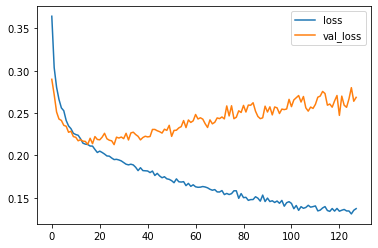

In [44]:
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

Plot the accuracies:

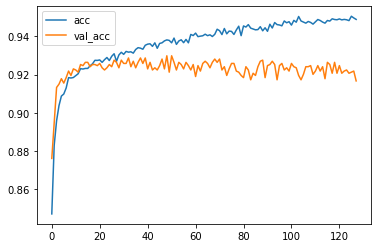

In [45]:
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label='val_acc')
plt.legend()

In [46]:
print(model.evaluate(X_test, y_test))

55/55 [==============================] - 0s 724us/step - loss: 0.2686 - accuracy: 0.9167
[0.268596887588501, 0.9166666865348816]


In [50]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(confusion_matrix(y_test, y_pred)) 

[[801  82]
 [ 91 778]]


In [68]:
model.save_weights('../weights/best25_features/')


**Applying this dataset on different models to create benchmarks to compare with Fully Connected model:**

*Logistic Regression* **(linear classifier):**

In [47]:
from sklearn.linear_model import LogisticRegression
model =LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))



0.8738424457693771
0.8721461187214612


In [48]:
for i in range(X_train[0].shape[0]):
 print("weight for the feature",i,":",model.coef_[0][i])

model.coef_[0].sort()

print("sorted list, positive weights contribute MORE TO DETERMINE potential hypertension case and negative features conribute more to make prediction as NOT hypertension. So we can say 0 valued weights do not contribute to anything:",model.coef_[0])

weight for the feature 0 : 0.21733941070314228
weight for the feature 1 : -0.004160888682481486
weight for the feature 2 : -0.08116337395550444
weight for the feature 3 : 0.01907570225224065
weight for the feature 4 : 0.0034820541766670695
weight for the feature 5 : -0.02323698214483446
weight for the feature 6 : 0.016011097201585927
weight for the feature 7 : -0.004769038853859348
weight for the feature 8 : 0.0012275948063656876
weight for the feature 9 : -0.05036278849747555
weight for the feature 10 : 0.05036278849747555
weight for the feature 11 : 0.0638641774332631
weight for the feature 12 : 0.03639477146130328
weight for the feature 13 : -0.04780659553618885
weight for the feature 14 : 0.05430853392070615
weight for the feature 15 : -0.04799029974057749
weight for the feature 16 : -0.04953864647228976
weight for the feature 17 : -3.4085412657068153
weight for the feature 18 : 0.042449639640983666
weight for the feature 19 : -0.11700568477510156
weight for the feature 20 : 0.1248

*Decision Tree*  

In [49]:
from sklearn.tree import DecisionTreeClassifier
model =DecisionTreeClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))

1.0
0.901255707762557


*AdaBoost*

In [147]:
from sklearn.ensemble import AdaBoostClassifier
model =AdaBoostClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test,y_test))

0.986135322495642
0.9850419554906968


In [148]:
unique, counts = np.unique(y_test, return_counts=True)
print("test:",dict(zip(unique, counts)))


unique, counts = np.unique(y_train, return_counts=True)
print("train:",dict(zip(unique, counts)))

test: {0: 2697, 1: 44}
train: {0: 24302, 1: 365}


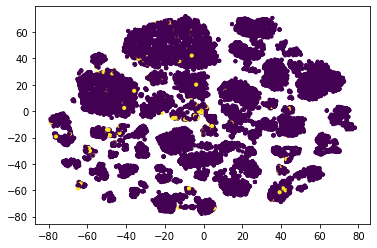

In [151]:
# Visualize the data (tsne is great but slow.)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(X_train)

#visualize in the 2d
plt.scatter(transformed[:,0], transformed[:,1], c=y_train, s=10) #take first two columns in order to get 2d plot.
plt.show()

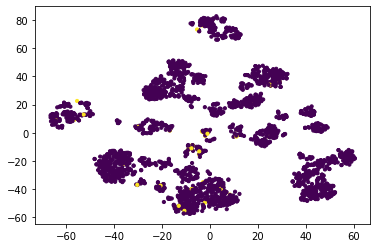

In [152]:
transformed = tsne.fit_transform(X_test)

# visualize the clouds in 2-D
plt.scatter(transformed[:,0], transformed[:,1], c=y_test, s=10) #take first two columns in order to get 2d plot.
plt.show()